In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import os, sys
opj = os.path.join
from tqdm import tqdm
from functools import partial
import acd
from copy import deepcopy
sys.path.append('..')
from transforms_torch import transform_bandpass, tensor_t_augment, batch_fftshift2d, batch_ifftshift2d
import transform_wrappers
sys.path.append('../dsets/mnist')
import dset
from model import Net, Net2c
from util import *
from torch import nn
from style import *
from captum.attr import *
import knockout
from attributions import *
import warnings
warnings.filterwarnings("ignore")
sys.path.append('../..')
from acd_wooseok.acd.scores import cd, score_funcs, cd_propagate

In [2]:
# define net
class Net2c_fft(nn.Module):
    def __init__(self):
        super(Net2c_fft, self).__init__()
        self.fc0 = nn.Linear(28*28*2, 28*28)
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.pool1 = nn.MaxPool2d(2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.pool2 = nn.MaxPool2d(2)
        self.relu2 = nn.ReLU()
        self.fc1 = nn.Linear(320, 50)
        self.relu3 = nn.ReLU()
        self.dropout = nn.Dropout()
        self.fc2 = nn.Linear(50, 2)

    def logits(self, x):
        x = self.fc0(x.reshape(x.shape[0], -1))
        x = x.reshape(-1, 1, 28, 28)
        x = self.relu1(self.pool1(self.conv1(x)))
        x = self.relu2(self.pool2(self.conv2_drop(self.conv2(x))))
        x = x.reshape(-1, 320)
        x = self.relu3(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x
        
    def forward(self, x):
        x = self.logits(x)
        return F.log_softmax(x, dim=1)

    def predicted_class(self, x):
        pred = self.forward(x)
        _, pred = pred[0].max(0)
        return pred.item() #data[0]


In [3]:
def train_Net2c(train_loader, args, t, transformer, save_path='models/cnn_vanilla.pth'):
    # seed
    random.seed(13)
    np.random.seed(13)
    torch.manual_seed(13)
    if device == 'cuda':
        torch.cuda.manual_seed(13)

    # model
    model = Net2c_fft().to(device)

    # optimizer
    optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)

    # train
    for epoch in range(1, args.epochs + 1):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            B = len(target)
            data = t(tensor_t_augment(data, transformer)).to(device)
            target = torch.ones(2*B, dtype=target.dtype).to(device)
            target[B:] = 0
            # zero grad
            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()
            if batch_idx % args.log_interval == 0:
                print('\rTrain Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * 2*B, 2*len(train_loader.dataset),
                           100. * batch_idx / len(train_loader), loss.data.item()), end='')

    torch.save(model.state_dict(), save_path)
    

# test Net2c
def test_Net2c(test_loader, model, t, transformer):
    # eval mode
    model = model.to(device)
    model.eval()

    # test
    test_loss = 0
    correct = 0
    for batch_idx, (data, target) in tqdm(enumerate(test_loader)):
        B = len(target)
        data = t(tensor_t_augment(data, transformer)).to(device)
        target = torch.ones(2*B, dtype=target.dtype).to(device)
        target[B:] = 0
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').data.item()  # sum up batch loss
        pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= 2*len(test_loader.dataset)
    return test_loss, correct        

In [4]:
# set args
args = dset.get_args()
args.epochs = 100

# load mnist data
train_loader, test_loader = dset.load_data(args.batch_size, args.test_batch_size, device)

# train model on the fft space

In [5]:
# train model
idx = 0
band_center = np.linspace(0.15, 0.85, 10)[idx]
band_width = 0.05
# FFT
t = lambda x: torch.fft(torch.stack((x, torch.zeros_like(x)),dim=4) , 2)
transform_i = transform_wrappers.modularize(lambda x: torch.ifft(x, 2)[...,0])
transformer = lambda x: transform_bandpass(x, band_center, band_width)

In [6]:
# train model
train_Net2c(train_loader, args, t, transformer, save_path=opj('models/freq','net2c_' + str(idx) + str(idx) + '.pth'))
model_t = Net2c_fft().to(device)
model_t.load_state_dict(torch.load(opj('models/freq','net2c_' + str(idx) + str(idx) + '.pth'), map_location=device))
# test model
test_loss, correct = test_Net2c(test_loader, model_t, t, transformer)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, 2*len(test_loader.dataset),
    100. * correct / (2*len(test_loader.dataset))))   

Train Epoch: 100 [119040/120000 (99%)]	Loss: 0.000000

10it [00:04,  2.45it/s]


Test set: Average loss: 0.0009, Accuracy: 19998/20000 (100%)


# scores in fft space

In [7]:
# model on the pixel space
model = Net2c().to(device)
model.load_state_dict(torch.load(opj('models/freq','net2c_' + str(idx) + '.pth'), map_location=device))
test_loss, correct = knockout.test_Net2c(test_loader, model, transformer)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
    test_loss, correct, 2*len(test_loader.dataset),
    100. * correct / (2*len(test_loader.dataset)))) 
m_t =  transform_wrappers.Net_with_transform(model=model, transform=transform_i).to(device)

10it [00:03,  2.99it/s]


Test set: Average loss: 0.0006, Accuracy: 19996/20000 (100%)


In [8]:
x, _ = iter(test_loader).next()
x = x[0:1].to(device)
x_t = t(x).to(device)
results1 = get_attributions(x_t, m_t, class_num=1)    
results2 = get_attributions(x_t, model_t, class_num=1)    

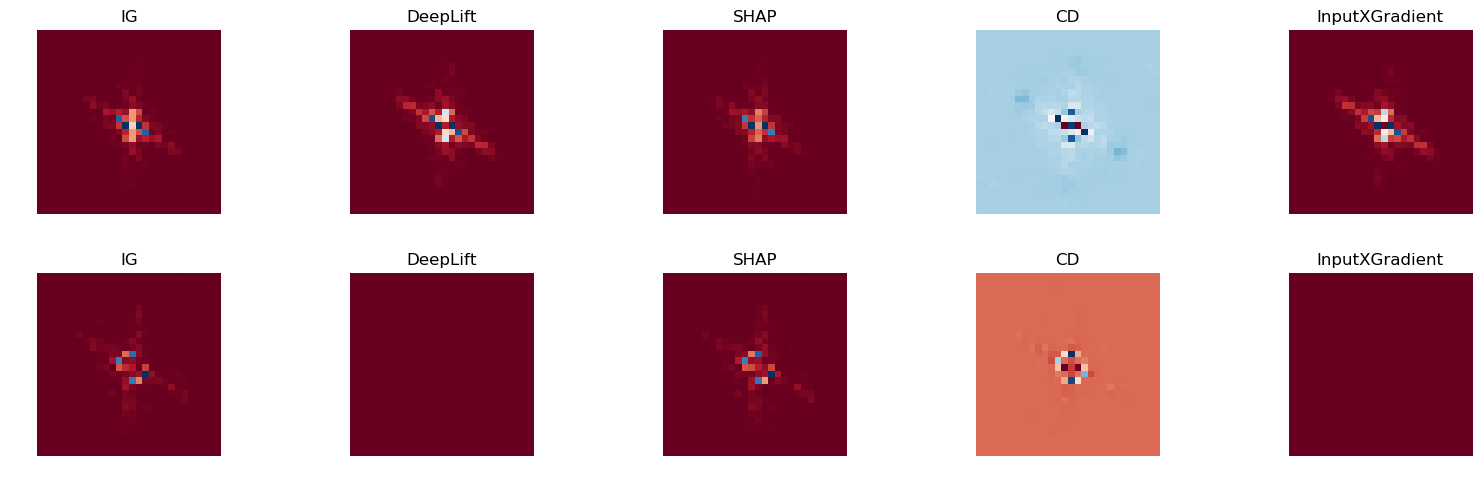

In [9]:
# get interp scores
attr_methods = ['IG', 'DeepLift', 'SHAP', 'CD', 'InputXGradient']

# viz scores in fft space
obs_idx = 0
plt.figure(figsize=(16, 5),dpi=100)
for i, name in enumerate(attr_methods):
    interp_scores = fftshift(results1[name].squeeze())
    plt.subplot(2, 5, i + 1)
    plt.imshow(interp_scores, cmap='RdBu')
    plt.title(name)
    plt.axis('off')
    interp_scores = fftshift(results2[name].squeeze())
    plt.subplot(2, 5, i + 6)
    plt.imshow(interp_scores, cmap='RdBu')
    plt.title(name)
    plt.axis('off')    
plt.tight_layout()
plt.show()

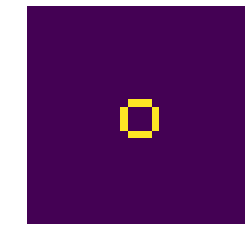

In [10]:
plt.imshow(freq_band(n=28, band_center=band_center, band_width=band_width))
plt.axis('off')
plt.show()